In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

import healpy as hp
import cartopy.feature as cfeature
import cartopy.crs as ccrs

from cartopy.io import shapereader
from shapely.geometry import Point
from haversine import haversine_vector, Unit
import torch

In [6]:
# dtypes = {
#     'ID':'int32',
#     'time':'int32',
#     'latitude':'float32',
#     'longitude':'float32',
#     'lon360':'float32',
#     'sst':'float32',
#     'err_sst':'float32',
#     've':'float32',
#     'vn':'float32',
#     'err_lat':'float32',
#     'err_lon':'float32',
# }

date_cols = ['time']


df = pd.read_csv("drifter_6hour_qc_723d_ea19_204a.csv",
                #  dtype=dtypes,
                 parse_dates=date_cols,
                 skiprows=[1])

In [7]:
len(df.ID.unique())

28706

In [8]:
df.dtypes

ID                         int64
time         datetime64[ns, UTC]
latitude                 float64
longitude                float64
lon360                   float64
sst                      float64
err_sst                  float64
ve                       float64
vn                       float64
err_lat                  float64
err_lon                  float64
dtype: object

In [ ]:
if False:
    # Step 1: Create the figure and ax with a geographic projection
    fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})

    # Step 2: Add a basic world map
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Optional: gridlines
    ax.gridlines(draw_labels=True)

    # Step 3: Set the extent (optional - to zoom into a specific region)
    # ax.set_extent([-180, 180, -90, 90])  # global view

    # Step 4: Plot your data (replace these with your actual data)
    for unique_id in tqdm(df.ID.unique()[0::1]):
        slice_df = df[df.ID == unique_id][["latitude", "longitude"]].astype(float)
        longitudes = slice_df['longitude'].to_numpy()
        latitudes = slice_df['latitude'].to_numpy()
        
        jumps = np.abs(np.diff(longitudes))
        split_indices = np.where(jumps > 180)[0] + 1
        
        lon_segments = np.split(longitudes, split_indices)
        lat_segments = np.split(latitudes, split_indices)

        for idx, lon_segment in enumerate(lon_segments):
            ax.plot(lon_segment, lat_segments[idx], transform=ccrs.PlateCarree(), color=(20/256, 148/256, 219/256,0.05))  # 'ro' for red dots

        # ax = df[df.ID == unique_id][["latitude", "longitude"]].plot(ax=ax, y="latitude", x = "longitude", legend=False)


    plt.savefig("Drifter Plot.png")


In [9]:
df_slice = df.loc[::1000]

longitudes = torch.from_numpy(df_slice.longitude.values)
latitudes = torch.from_numpy(df_slice.latitude.values)
north_velocities = torch.from_numpy(df_slice.vn.values)
east_velocities = torch.from_numpy(df_slice.ve.values)

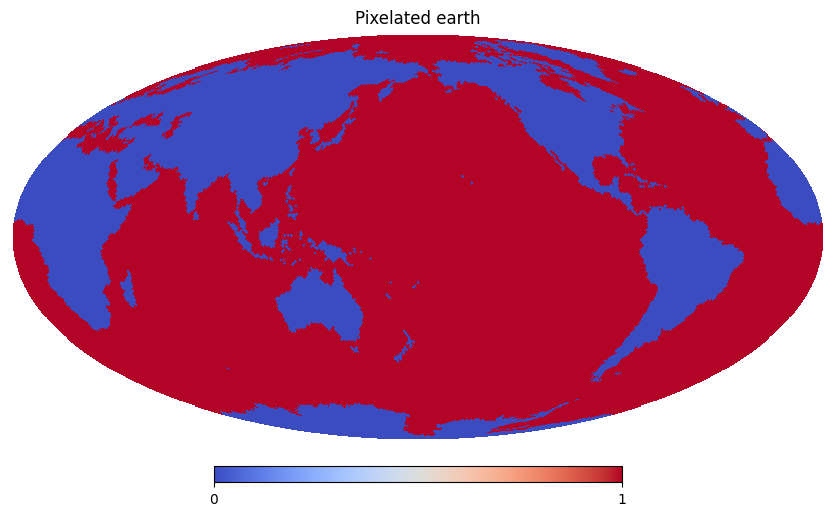

In [10]:
# 1. Creating a world grid

# healpy is designed to provide pixelated data on a sphere. It will help us pixelate the earth into a discretised grid which we can then do our approximations on.

nside = 64  # Set the resolutio of the grid. (Given by power of 2)
npix = hp.nside2npix(nside) #Returns optimum number of pixels required

theta, phi = hp.pix2ang(nside, np.arange(npix)) # Returns the centre of a discretised grid of points for the specified number of pixels

grid_latitudes = torch.from_numpy(np.degrees(0.5 * np.pi - theta)) # Convert centre into latitude and longitude measurements
grid_longitudes = torch.from_numpy(180 - np.degrees(phi))

land_shpfilename = shapereader.natural_earth(resolution='110m',
                                              category='physical',
                                              name='land') # Get land polygons from Natural Earth data
land_geoms = list(shapereader.Reader(land_shpfilename).geometries())



ocean_values = np.ones(npix, dtype=np.uint8) # Mask to set oceans. 0 for land

for i in range(npix):
    point = Point(grid_longitudes[i], grid_latitudes[i])
    if any(geom.contains(point) for geom in land_geoms):
        ocean_values[i] = 0  # land


v_velocity = np.zeros(npix, dtype=np.float32) # Ocean data matrix initialised to 0.
u_velocity = np.zeros(npix, dtype=np.float32) # Ocean data matrix initialised to 0.


hp.mollview(ocean_values, title="Pixelated earth", cmap='coolwarm') # mollview is a special function that assumes the correct length of the mask variable.
plt.show()


In [ ]:
# 2. Loop over each point in the grid
# If the grid is land ignore.
# If the grid is water, fetch floaters that are within a certain distance of the point.
# Perform a gaussian smoothing on them to guess the velocity

def geodesic_distance_torch(ref_lat, ref_lon, batch_lat, batch_lon, radius=6371.0):
    """
    Approximate geodesic distance on Earth using Haversine formula.
    Inputs:
      - ref_lat, ref_lon: scalars (reference point) in degrees or tensors broadcastable to batch_lat/batch_lon
      - batch_lat, batch_lon: tensors of points in degrees
    Returns:
      - distances tensor (in kilometers)
    """
    # convert degrees to radians
    ref_lat = torch.deg2rad(ref_lat)
    ref_lon = torch.deg2rad(ref_lon)
    batch_lat = torch.deg2rad(batch_lat)
    batch_lon = torch.deg2rad(batch_lon)

    dlat = batch_lat - ref_lat
    dlon = batch_lon - ref_lon

    a = torch.sin(dlat / 2) ** 2 + torch.cos(ref_lat) * torch.cos(batch_lat) * torch.sin(dlon / 2) ** 2
    c = 2 * torch.atan2(torch.sqrt(a), torch.sqrt(1 - a))

    return radius * c

b = 1000

for idx, u_idx in tqdm(enumerate(v_velocity)):
    if ocean_values[idx]==1:
      this_lat = grid_latitudes[idx]
      this_lon = grid_longitudes[idx]
      

      distances = geodesic_distance_torch(this_lat, this_lon, latitudes, longitudes)
      kernel_weights = torch.exp(-distances**2 / (2 * b**2))
      kernel_weights[north_velocities==-999999.0] = 0 # Missing data catch. Missing entries are encoded as -999999.0

      
      v_velocity[idx] = (north_velocities * kernel_weights).sum() / kernel_weights.sum()
      u_velocity[idx] = (east_velocities * kernel_weights).sum() / kernel_weights.sum()


0it [00:00, ?it/s]

: 

In [ ]:

mask = (ocean_values == 1)

lat_ocean = grid_latitudes[mask]
lon_ocean = grid_longitudes[mask]
X_ocean = v_velocity[mask]


# Step 1: Create the figure and ax with a geographic projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Step 2: Add a basic world map
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Optional: gridlines
ax.gridlines(draw_labels=True)
sc = ax.scatter(lon_ocean, lat_ocean, c=X_ocean, cmap='viridis', marker='o', s=10)
plt.colorbar(sc, label='North velocity')


plt.savefig("Northvelocity_gaussiansmooth_b1000.png")


In [ ]:

mask = (ocean_values == 1)

lat_ocean = grid_latitudes[mask]
lon_ocean = grid_longitudes[mask]
X_ocean = u_velocity[mask]


# Step 1: Create the figure and ax with a geographic projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Step 2: Add a basic world map
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Optional: gridlines
ax.gridlines(draw_labels=True)
sc = ax.scatter(lon_ocean, lat_ocean, c=X_ocean, cmap='viridis', marker='o', s=10)
plt.colorbar(sc, label='East velocity')


plt.savefig("Eastvelocity_gaussiansmooth_b1000.png")
